In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

'''
You will be creating your very own AI classifier for psychiatry from the BRFSS 2022 data. 

You are allowed to predict the classification of any target column in the BRFSS data as long as 
it is related to psychiatry. The target must be binary i.e. either belong to class 0 or class 1.

You are also able to choose any set of covariates you'd like as inputs to your model.

Finally, you can choose which types of participants you'd like in your study. For example, you can 
subset the study to only those that live in Florida... or only those that have a depression history...

The objective of this AI model is up to you. Your goal can be to understand the risk factors of a condition
for a certain group of people... Or it can be to maximize classifcation accuracy.

There are several AI models that can be used. I'd recommend trying all of them to see which gets the best results.
If you are trying to increase performance, then you can play with the model's hyperparameters i.e. specifications
to see what best helps the model 

'''

'''
1. Make sure that this file is in the same folder as LLCP2022_shuffled.csv
2. Run this commands in terminal (if mac) or conda environment (if windows)
    conda install scikit-learn
    conda install -c conda-forge xgboost

3. Set your target outcome variable. This is the variable that you are trying to predict. 
It will have to be binarized as we are performing classification
4. Set the number of rows you would like to load from BRFSS. Start small when playing around (~30k), 
then use all the data for final analysis (450k) if your compute allows it.
'''

# INPUT VARIABLE
# Target Variable
TARGET = 'MENTHLTH' 
# # Number of samples
N_SAMPS = 200000 
# TARGET = 'MARITAL'
# N_SAMPS = 50000

'''
5. Set your Inclusion Criteria

This dictionary sets the inclusion criteria for your study i.e. only participants that had the following survey 
responses are included. This is important if your want to look at a certain subset of partipicants in your study 
like women or men. Make sure that your target column is part of the inclusion criterion so that participants that 
have a  null response in this section are filtered out i.e. every target survey response should be a real response.

How to adjust this inclusion criteria:

1. Starting point:

        inclusion_criteria = {}
        
2. Add inclusion criteria for a given column. Make sure column name is in paratheses

        inclusion_criteria = {'COLUMN_NAME'}

3. Add :

        inclusion_criteria = {'COLUMN_NAME': }
        
4. Add responses for that column that are required in order to be included in your study. These responses must be 
   a list i.e. [1,10,33].
   
        inclusion_criteria = {'COLUMN_NAME': [1,10,33]}
        
   If you need to add numbers between 0 and 30, you can just put in list(range(0,30))

        inclusion_criteria = {'COLUMN_NAME': list(range(0,30))}
        
   If you want manually add values and have range of numbers, you can concatentate the two lists
    
        inclusion_criteria = {'COLUMN_NAME': list(range(0,30))+[1,10,33]}
        
5. Make sure that before adding another inclusion criterion i.e. column, you add a ,

        inclusion_criteria = {'COLUMN_NAME': list(range(0,30))+[1,10,33],}
        
        Thus, if you had two criteria it would look like this
        
        inclusion_criteria = {'COLUMN_NAME1': list(range(0,30))+[1,10,33],
                              'COLUMN_NAME2': [0,1,2],}
   
'''

# This sets an inclusion criteria of everyone that has a history of depression and filled out the MENTHLTH section
# You can set the inclusion criteria to whatever you want.
# OUTPUT VARIABLE
inclusion_criteria = {
                      'ADDEPEV3': [1], # Has history of depression
                      'MENTHLTH': list(range(0,31))+[88], # Has real response for MENTHLTH
                      #'MARITAL': {0: list(range(3,9))+[1]+[9], 1: [2]}
                     }

'''
6. Determine the covariates and the values of the covariates you would like to include in your study

How to adjust this covariate mapping:

1. Starting point:

        categorical_covars = {}
        
2. Add covariate mapping for a given column. Make sure column name is in paratheses

        inclusion_criteria = {'COLUMN_NAME'}

3. Add : {}

        inclusion_criteria = {'COLUMN_NAME': {}}
        
4. Add mappings between survey responses and values you would like to include 
   
        categorical_covars = {'COLUMN_NAME': {[1,10,33]}}
        
   Then add the value you would like the responses to be mapped to as follows
   
       categorical_covars = {'COLUMN_NAME':  {5: [1,10,33]}}
       
   This will set the survey responses that are either 1, 10, or 33 to 5 in your study
        
   For values that will remain unchanged, specify 'keep' and the unchanged values

        categorical_covars = {'COLUMN_NAME': {'keep': [1,10,33]}}
        
    This way, survey values of 1, 10, 33 will be 1, 10, 33 in our input data respectively
        
   You also must specify how null values are filled in and which survey values are considered null values.
   For example, if the null values are 88 and 77 and we want to replace these values with the mode, we do as follows:
    
        categorical_covars = {'COLUMN_NAME': {'mode': [88, 77]}}
        
    If we want to replace null values with the average value, we do:
    
        categorical_covars = {'COLUMN_NAME': {'mean': [88, 77]}}
        
    We can incorporate everything as follows with commas:
    
        categorical_covars = {'COLUMN_NAME': {5: [1,10,33],
                                              'keep': list(range(0,30)),
                                              'mean': [88, 77]}}
        
5. Make sure that before adding another inclusion criterion i.e. column, you add a , as before

        categorical_covars = {'COLUMN_NAME1': {5: [1,10,33],
                                              'keep': list(range(0,30)),
                                              'mean': [88, 77]}, 
                              'COLUMN_NAME2': {5: [1,10,33],
                                              'keep': list(range(0,30)),
                                              'mean': [88, 77]}}
   
'''

# This added several covaraites to your dataframe
# Mental health variable is binarized such that values 0 to 5 are mapped to class 0 and values 5 to 30 are mapped to 
# class 1
categorical_covars = {
                      # male = 1; female = 2
                      'SEXVAR': {0: [2], 1: [1], 'mode': []}, # Set males to 0 and females to 1
                      'MENTHLTH': {0: list(range(0,5))+[88], 1: list(range(5,31)), 'mode': []}, # if MENTHLTH<5; set to 0, else set to 1
                      #'ADDEPEV3': [1], # Has history of depression
                      'MARITAL': {0: list(range(3,9))+[1]+[9], 1: [2], 'mode': []},
                      'RENTHOM1': {0: [2]+[3]+[7]+[9], 1: [1], 'mode': []}, # OWN
                      #'RENTHOM1': {0: [1]+[3]+[7]+[9], 1: [2], 'mode': []}, # RENT
                      'INCOME3': {0: [7]+[8]+[9]+[10]+[11]+[77]+[99], 1: [1]+[2]+[3]+[4]+[5]+[6], 'mode': []}, # MAKE LESS THAT $75,000
                      #'ACEDEPRS': {0: [2]+[7]+[9], 1: [1], 'mode': []}, # YES
                      #'ACEDRINK': {0: [2]+[7]+[9], 1: [1], 'mode': []}, # YES
                      #'ACEDRUGS': {0: [2]+[7]+[9], 1: [1], 'mode': []}, # YES
                      #'ACEPRISN': {0: [2]+[7]+[9], 1: [1], 'mode': []}, # YES
                      #'ACEDIVRC': {0: [2]+[7]+[8]+[9], 1: [1], 'mode': []}, # YES
                      #'ACESWEAR': {0: [1]+[7]+[9], 1: [2]+[3], 'mode': []} # YES, once or more than once
                     }

In [2]:
'''
    DO NOT TOUCH
'''

def filter_df_by_inclusion_criteria(df, inclusion_dict):
    for column, values in inclusion_dict.items():
        to_print = f'Only included participants were column {column} contains: {values}'
        print(to_print)
        df = df[df[column].isin(values)]
    df = df.dropna(subset=inclusion_dict.keys())
    return df

def encode_categorical(df, categorical_covars):
    n_total = df.shape[0]
    
    df = df[list(categorical_covars.keys())].copy()
    for column, mapping in categorical_covars.items():
        unique_vals = df[column].unique()
        unique_vals = unique_vals[~np.isnan(unique_vals)]
        mapped_items = []
        for new_val, old_vals in mapping.items():
            mapped_items += old_vals
            if type(new_val) is not str:
                df.loc[df[column].isin(old_vals), column] = new_val
            elif new_val == 'keep':
                pass
            else:
                df.loc[df[column].isin(old_vals), column] = np.nan
        
        set_difference = set(unique_vals) - set(mapped_items)
        if len(set_difference) > 0:
            to_print = f'WARNING: Responses {set_difference} are not accounted from in column {column}'
            print(to_print)
    
    for column in df.columns:
        n_missing = df[column].isnull().sum()
        p = 100*(n_missing/n_total)
        
        to_print = f'{column} has {p:.2f}% of values missing'
        print(to_print)
        
    for column, mapping in categorical_covars.items():
        if 'mean' in mapping:
            mean_val = df[column].mean()
            df[column].fillna(mean_val, inplace=True)
        elif 'mode' in mapping:
            mode_val = df[column].mode()[0]
            df[column].fillna(mode_val, inplace=True)
                
    return df

brfss_file = 'LLCP2022_shuffled.csv'
df = pd.read_csv(brfss_file, nrows=N_SAMPS)

to_print = f'Original total number of participants: {df.shape[0]} \n'
print(to_print)

df = filter_df_by_inclusion_criteria(df, inclusion_criteria)

to_print = f'\nFiltered number of participants: {df.shape[0]} \n'
print(to_print)

print('Checking Missingness of Data')
df = encode_categorical(df, categorical_covars)

print('\n')
for column in df.columns:
    unique_vals = sorted(df[column].unique().tolist())
    to_print = f'{column} has the following unique values: {unique_vals}'
    print(to_print)
    
    if column == TARGET and len(unique_vals) != 2:
        print('WARNING: the TARGET column must have 2 values (0 and 1)')
    
p_0 = (df[column] == 0).sum()/df.shape[0]

print('\nBaseline Classification on outcome: ', max(p_0, np.abs(1-p_0)))
    
print('\nCreating Training and Testing Data')

n_train = int(.75*df.shape[0])

Xy_train = df[:n_train]
Xy_test = df[n_train:]

X_train = Xy_train.drop(columns=[TARGET])
y_train = Xy_train[TARGET]
X_test = Xy_test.drop(columns=[TARGET])
y_test = Xy_test[TARGET]

mean = X_train.mean()
std = X_train.std()

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

to_print = f'Number of Training Data: {Xy_train.shape[0]}'
print(to_print)
to_print = f'Number of Testing Data: {Xy_test.shape[0]}\n'
print(to_print)

print(y_train.unique())

Original total number of participants: 200000 

Only included participants were column ADDEPEV3 contains: [1]
Only included participants were column MENTHLTH contains: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 88]

Filtered number of participants: 40061 

Checking Missingness of Data
SEXVAR has 0.00% of values missing
MENTHLTH has 0.00% of values missing
MARITAL has 0.00% of values missing
RENTHOM1 has 0.00% of values missing
INCOME3 has 2.26% of values missing


SEXVAR has the following unique values: [0.0, 1.0]
MENTHLTH has the following unique values: [0.0, 1.0]
MARITAL has the following unique values: [0.0, 1.0]
RENTHOM1 has the following unique values: [0.0, 1.0]
INCOME3 has the following unique values: [0.0, 1.0]

Baseline Classification on outcome:  0.5793914280721899

Creating Training and Testing Data
Number of Training Data: 30045
Number of Testing Data: 10016

[0. 1.]


Train MSE: 0.23258067645905656
Test MSE: 0.23183512933593692
Train R2 Score: 0.029912176715120586
Test R2 Score: 0.03252559916085784


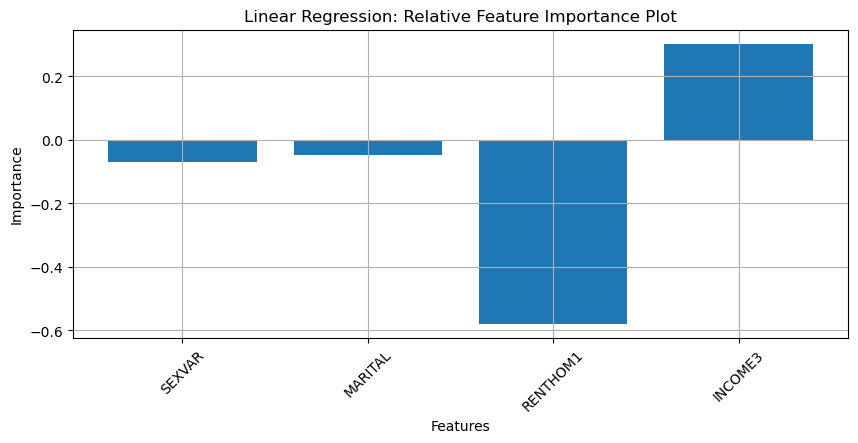

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

'''
Code to run Linear Regression

Documentation: 
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
'''

# Learn a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Prediction on train and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Metrics calculation for train and test sets
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Train MSE:", train_mse)
print("Test MSE:", test_mse)
print("Train R2 Score:", train_r2)
print("Test R2 Score:", test_r2)

# Feature importance plot
feature_importance = model.coef_/abs(model.coef_).sum()
plt.figure(figsize=(10, 4))
plt.bar(X_train.columns, feature_importance)
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Linear Regression: Relative Feature Importance Plot')
plt.grid()
plt.show()

Train classification accuracy: 0.599234481610917
Test classification accuracy: 0.5987420127795527


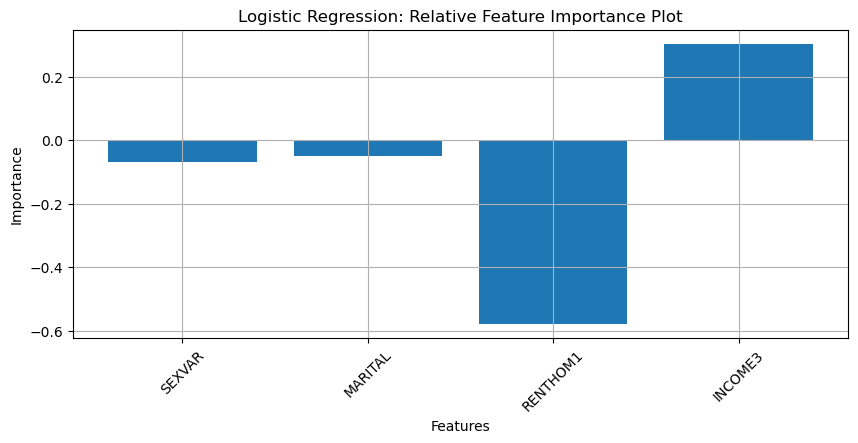

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

'''
Code to run Logisitc Regression

Documentation: 
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
'''

# Learn a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Classification on train and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Classification accuracy on train and test sets
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Train classification accuracy:", train_accuracy)
print("Test classification accuracy:", test_accuracy)

# Feature importance plot
feature_importance = model.coef_[0]/abs(model.coef_[0]).sum()
plt.figure(figsize=(10, 4))
plt.bar(X_train.columns, feature_importance)
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Logistic Regression: Relative Feature Importance Plot')
plt.grid()
plt.show()

Train classification accuracy: 0.6012314861041771
Test classification accuracy: 0.6018370607028753


Text(0.5, 1.0, 'SVM: Relative Feature Importance Plot')

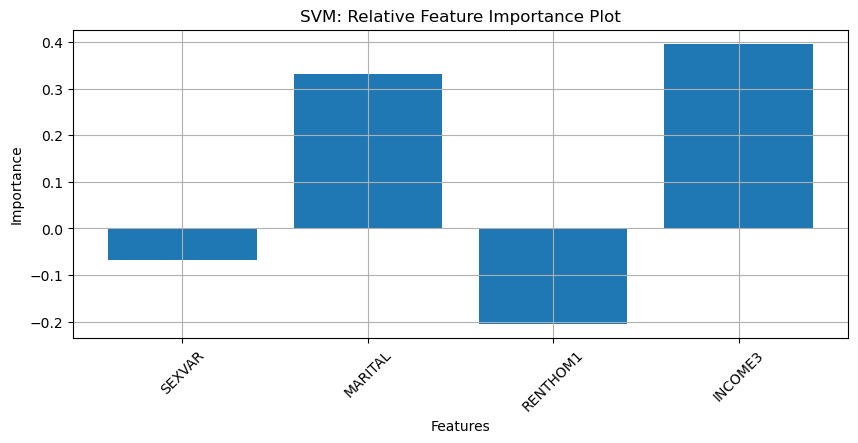

In [5]:
from sklearn.svm import SVC

'''
Code to run Support Vector Machines

Documentation: 
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
'''

model = SVC(kernel='linear')
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Train classification accuracy:", train_accuracy)
print("Test classification accuracy:", test_accuracy)

feature_importance = model.coef_[0]/abs(model.coef_[0]).sum()
plt.figure(figsize=(10, 4))
plt.bar(X_train.columns, feature_importance)
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.grid()
plt.title('SVM: Relative Feature Importance Plot')


Train classification accuracy: 0.6031952071892162
Test classification accuracy: 0.6058306709265175
Note that the feature importances can only be positive


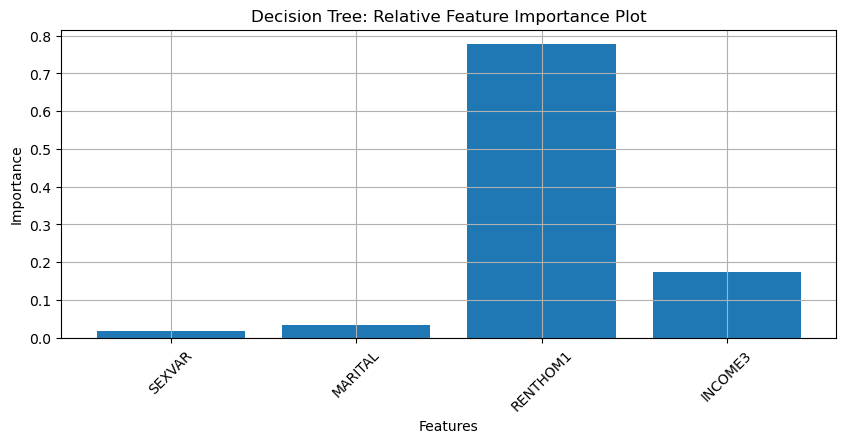

In [6]:
from sklearn.tree import DecisionTreeClassifier

'''
Code to run Decision Trees

Documentation: 
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
'''

model = DecisionTreeClassifier()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Train classification accuracy:", train_accuracy)
print("Test classification accuracy:", test_accuracy)
print("Note that the feature importances can only be positive")

feature_importance = model.feature_importances_
plt.figure(figsize=(10, 4))
plt.bar(X_train.columns, feature_importance)
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Decision Tree: Relative Feature Importance Plot')
plt.grid()

Train classification accuracy: 0.6031952071892162
Test classification accuracy: 0.6058306709265175
Note that the feature importances can only be positive


Text(0.5, 1.0, 'XGBoost: Feature Importance Plot')

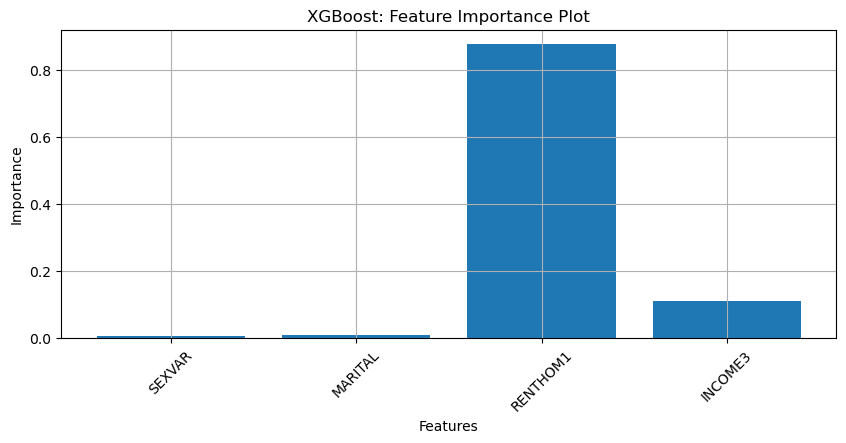

In [7]:
from xgboost import XGBClassifier

'''
Code to run XGBoost

Documentation: 
https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier.feature_importances_
'''

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Train classification accuracy:", train_accuracy)
print("Test classification accuracy:", test_accuracy)
print("Note that the feature importances can only be positive")


feature_importance = model.feature_importances_
plt.figure(figsize=(10, 4))
plt.bar(X_train.columns, feature_importance)
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.grid()
plt.title('XGBoost: Feature Importance Plot')